<a href="https://colab.research.google.com/github/caiocesarcosta/transform-image-gray-binary-project2/blob/main/transform_image_gray_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Tamanho da imagem lida: 69214 bytes
Primeiros 100 bytes da imagem: b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05'
Cabeçalho JPEG encontrado!
Dimensões encontradas: 512x512


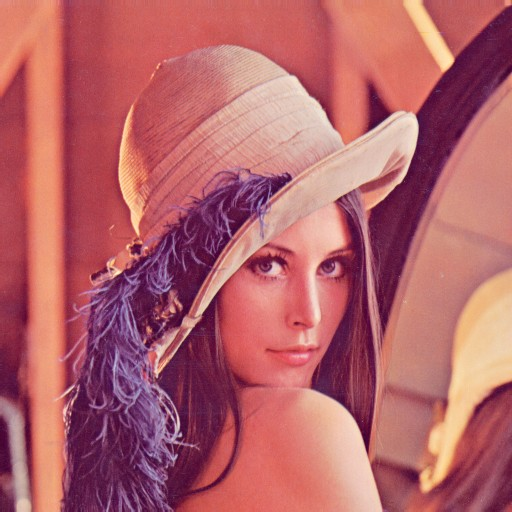

Largura da imagem: 512
Altura da imagem: 512
Shape inicial do array em tons de cinza: (512, 512)
Shape final do array em tons de cinza: (512, 512)


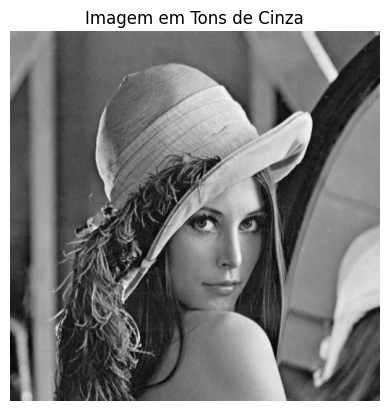

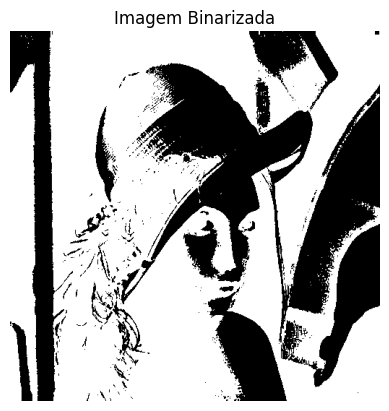

In [61]:
import numpy as np
from google.colab import drive
import os
import matplotlib.pyplot as plt
import pdb
from PIL import Image as PILImage # importando a biblioteca PIL
import io

class Image:
    def __init__(self, width, height, imageBytes):
        self.width = width
        self.height = height
        self.imageBytes = imageBytes

    def isImage(self, imageBytes):
        return imageBytes is not None

    def showImage(self, arr, title, cmap='gray'):
        """Exibe a imagem usando matplotlib."""
        try:
            plt.imshow(arr, cmap=cmap)
            plt.axis('off')
            plt.title(title)
            plt.show()
        except Exception as e:
            print(f"Erro ao exibir a imagem: {e}")


class ImageGrayScale(Image):
    def __init__(self, width, height, imageBytes):
        super().__init__(width, height, imageBytes)
        self.imageGray = None
        self.weightRed = 0.2989
        self.weightGreen = 0.5870
        self.weightBlue = 0.1140

        if self.width and self.height:
            image = PILImage.open(io.BytesIO(self.imageBytes)) # criando um objeto de imagem PIL a partir dos bytes
            image_np = np.array(image) # convertendo para array numpy
            self.imageGray = self._rgbToGrayscale()

    def _rgbToGrayscale(self):
        """Simula a conversão RGB para escala de cinza usando numpy."""
        image = PILImage.open(io.BytesIO(self.imageBytes)) # criando um objeto de imagem PIL a partir dos bytes
        imageRGB = np.array(image) # convertendo para array numpy

        # Criar um array numpy de zeros para armazenar os tons de cinza.
        grayImage = np.zeros((self.height, self.width), dtype=np.uint8)
        print(f"Shape inicial do array em tons de cinza: {grayImage.shape}")

        # Iterar sobre cada pixel da imagem RGB
        for y in range(self.height):
            for x in range(self.width):
                # Extrai os valores RGB
                blue = imageRGB[y, x, 0]
                green = imageRGB[y, x, 1]
                red = imageRGB[y, x, 2]
                #print(f"Pixel ({y}, {x}): B={blue}, G={green}, R={red}")

                # Calcular a média ponderada
                grayValue = int(self.weightRed*red + self.weightGreen*green + self.weightBlue*blue) # converter para int para evitar erros
                grayImage[y, x] = grayValue # gravar o novo valor no array de tons de cinza
                #print(f"Valor em tons de cinza do pixel ({y}, {x}): {gray_value}")
        print(f"Shape final do array em tons de cinza: {grayImage.shape}")
        return grayImage


class ImageBinary(Image):
    def __init__(self, width, height, imageByte, grayImage):
        super().__init__(width, height, imageByte)
        self.imageBinary = None
        self.threshold = 128
        if self.isImage(grayImage):
            self.imageBinary = self._binarizeImage(grayImage, self.threshold)

    def _binarizeImage(self, grayImage, threshold):
        """Binariza a imagem em escala de cinza usando um limiar."""
        if grayImage is None:
            return None
        try:
            binary_image = (grayImage > threshold).astype(np.uint8) * 255
            return binary_image
        except Exception as e:
            print(f"Erro na binarização: {e}")
            return None


class FileManagement:
    _drive_mounted = False

    def __init__(self, image_path):
        self.imagePath = image_path
        self.imageBytes = None
        self.width = 0
        self.height = 0

        if not FileManagement._drive_mounted:
            try:
                drive.mount('/content/drive', force_remount=True)
                FileManagement._drive_mounted = True
            except Exception as e:
                print(f"Erro ao montar o Google Drive: {e}")
                return None

        self.imageBytes = self.readImageFromDrive()
        if self.imageBytes is not None:
            self.width, self.height = self._getImageDimensions()

    def readImageFromDrive(self):
        """Lê uma imagem do Google Drive e retorna como bytes, verificando se a leitura está completa."""
        try:
            if not os.path.exists(self.imagePath):
                print(f"Erro: Arquivo não encontrado: {self.imagePath}")
                return None

            with open(self.imagePath, 'rb') as f:
                image_data = f.read()

            print(f"Tamanho da imagem lida: {len(image_data)} bytes")

            # Imprimir os primeiros 100 bytes para verificar o cabeçalho
            print(f"Primeiros 100 bytes da imagem: {image_data[:100]}")

            return image_data
        except Exception as e:
            print(f"Erro ao ler a imagem: {e}")
            return None

    def _getImageDimensions(self):
        """Tenta determinar as dimensões de uma imagem JPEG a partir de seus bytes."""
        image_bytes = self.imageBytes
        if image_bytes is None:
            return None, None
        try:
            pos = 0

            # Verificar se o arquivo começa com o cabeçalho JPEG
            if image_bytes[pos] == 0xFF and image_bytes[pos + 1] == 0xD8:
                print("Cabeçalho JPEG encontrado!")

            while pos < len(image_bytes):
                if image_bytes[pos] == 0xFF:
                    # Verifica se encontrou o marcador SOF0 (0xC0) que contém as dimensões
                    if pos + 1 < len(image_bytes) and image_bytes[pos + 1] == 0xC0:
                        # Os bytes 5 a 8 contêm a altura e a largura
                        height = (image_bytes[pos + 5] << 8) | image_bytes[pos + 6]
                        width = (image_bytes[pos + 7] << 8) | image_bytes[pos + 8]
                        print(f"Dimensões encontradas: {width}x{height}")
                        return width, height
                    # Verifica se encontrou o marcador EOI (End of Image - 0xD9)
                    elif pos + 1 < len(image_bytes) and image_bytes[pos + 1] == 0xD9:
                        print("Marcador de fim de imagem (EOI) encontrado antes de SOF0.")
                        break
                pos += 1

            return None, None  # Caso não encontre o marcador SOF0
        except Exception as e:
            print(f"Erro ao ler dimensões da imagem: {e}")
            return None, None

    def showImage(self):
        """Exibe a imagem carregada no Google Drive."""
        if self.imageBytes is None:
            print("Erro: Imagem não carregada para exibição.")
            return
        try:
            from IPython.display import Image, display
            display(Image(data=self.imageBytes))
        except Exception as e:
            print(f"Erro ao exibir a imagem: {e}")


# Exemplo de uso:
imagePath = '/content/drive/MyDrive/lena/lena.jpg'

fileManager = FileManagement(imagePath)
fileManager.showImage()

width = fileManager.width
height = fileManager.height

if fileManager.imageBytes:
    print(f"Largura da imagem: {width}")
    print(f"Altura da imagem: {height}")

    imageGray = ImageGrayScale(width, height, fileManager.imageBytes)
    imageGray.showImage(imageGray.imageGray, "Imagem em Tons de Cinza", cmap='gray')

    imageBinary = ImageBinary(width, height, fileManager.imageBytes, imageGray.imageGray)
    imageBinary.showImage(imageBinary.imageBinary, "Imagem Binarizada", cmap='binary')